## Import stuff

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import thinplate as tps
import cv2

In [2]:
def show_warped(img, warped, c_src, c_dst):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].imshow(img[...,::-1], origin='upper')
    axs[0].scatter(c_src[:, 0]*img.shape[1], c_src[:, 1]*img.shape[0], marker='+', color='black')
    axs[1].imshow(warped[...,::-1], origin='upper')
    axs[1].scatter(c_dst[:, 0]*warped.shape[1], c_dst[:, 1]*warped.shape[0], marker='+', color='black')
    plt.show()
def warp_image_cv(img, c_src, c_dst, dshape=None):
    dshape = dshape or img.shape
    theta = tps.tps_theta_from_points(c_src, c_dst, reduced=True)
    grid = tps.tps_grid(theta, c_dst, dshape)
    mapx, mapy = tps.tps_grid_to_remap(grid, img.shape)
    return cv2.remap(img, mapx, mapy, cv2.INTER_CUBIC)

## Thin Plate Spline

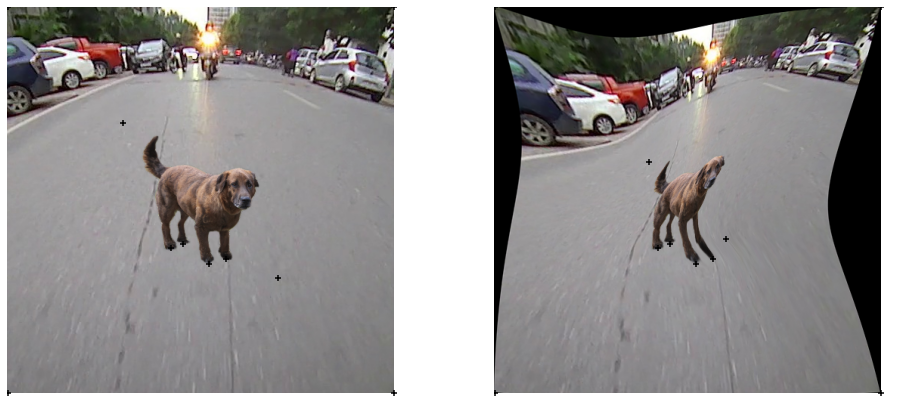

In [3]:
img = cv2.imread('./svm_samples/images/4.png')
c_src = np.array([
    [0.0, 0.0],
    [1., 0],
    [1, 1],
    [0, 1],
    [0.3, 0.3],
    [0.7, 0.7],
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])

c_dst = np.array([
    [0., 0],
    [1., 0],    
    [1, 1],
    [0, 1],
    [0.4, 0.4],
    [0.6, 0.6],
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])

warped = warp_image_cv(img, c_src, c_dst)
# warped = warp_image_cv(img, c_src, c_dst, dshape=(512, 512))
show_warped(img, warped)

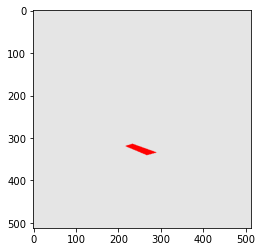

In [49]:
shadow_mask = np.zeros((512,512,3))+(0.9,0.9,0.9)
pts = np.array([[217,319],[233,314],[289,334],[267,340]], np.int32)
# pts = pts.reshape((2,0))
# pts = pts.reshape((-1,1,2))
cv2.fillPoly(shadow_mask,[pts],color=(1,0,0))
plt.imshow(shadow_mask, origin='upper')
# plt.imshow(img[...,::-1], origin='upper')

In [15]:
shadow_mask.shape

(512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


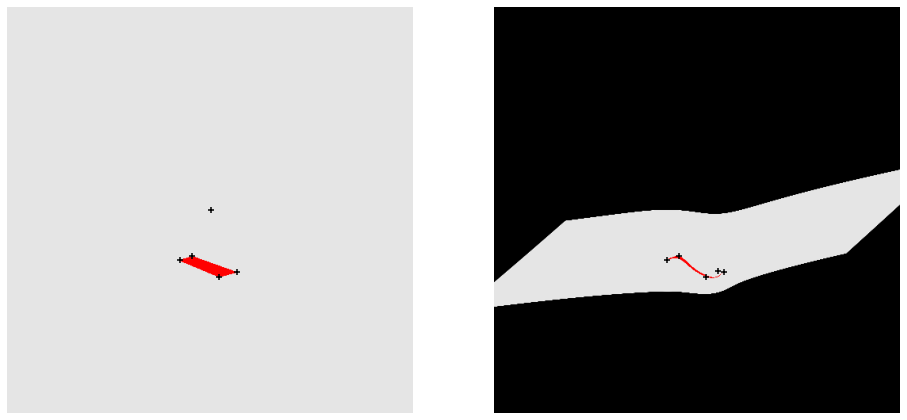

In [142]:
c_src = np.array([
    [0.5, 0.5],
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])

c_dst = np.array([
    [0.55, 0.65],
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])
warped = warp_image_cv(shadow_mask[...,::-1], c_src, c_dst)
# warped = warp_image_cv(img, c_src, c_dst, dshape=(512, 512))
show_warped(shadow_mask[...,::-1], warped)

## Other

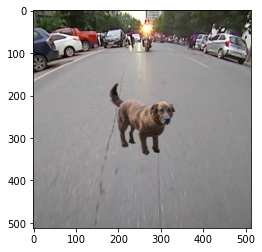

In [3]:
img = cv2.imread('./svm_samples/images/4.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

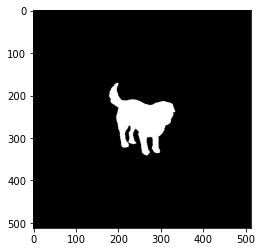

In [4]:
mask = cv2.imread('./svm_samples/foreground_object_mask/4.png')
plt.imshow(mask[...,::-1])

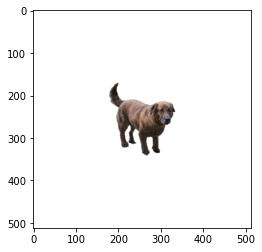

In [5]:
background=cv2.subtract(img,mask)
cut_obj=cv2.subtract(img,background)
white_bg = np.zeros((512,512,3), dtype='uint8')+255
white_bg=cv2.subtract(white_bg,mask)
new_img = cut_obj+white_bg
plt.imshow(new_img[...,::-1])

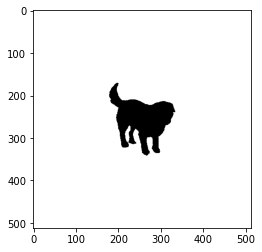

In [6]:
shadow = 255-mask
plt.imshow(shadow)

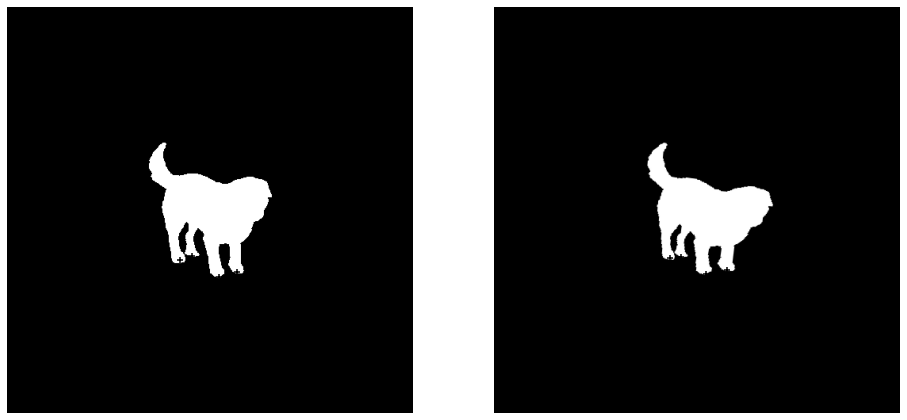

In [54]:
def gen_warped_img(img, fixed_pts, src=None, dst=None):
    if src is None or dst is None:
        src = np.random.uniform(low=0.05, high=0.15, size=(1,2))
        dst = np.random.uniform(low=0.05, high=0.15, size=(1,2))
    assert src.shape == (1,2) and dst.shape == (1,2), "src and dst shape is not (1,2)"
    delta = np.random.uniform(low=-0.01, high=0.01, size=fixed_pts.shape)
    c_src = np.vstack((src, fixed_pts))
    c_dst = np.vstack((dst, fixed_pts+delta))
    return warp_image_cv(img, c_src, c_dst), c_src, c_dst

fixed_pts = np.array([
    [0.423828125, 0.623046875],#(217,319)
    [0.455078125, 0.61328125],#(233,314)
    [0.521484375, 0.6640625],#(267,340)
    [0.564453125, 0.65234375],#(289,334)
])
warped, c_src, c_dst = gen_warped_img(mask, fixed_pts)
show_warped(mask[...,::-1], warped[...,::-1], c_src, c_dst)

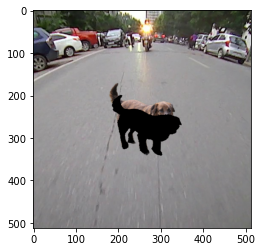

In [8]:
shadow_black = 255-warped
shadow_black=cv2.subtract(img,warped)
plt.imshow(shadow_black[...,::-1])

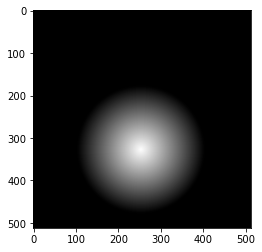

In [11]:
#large radius => darker around center
# def create_grad_img(center, radius, thickness = 2):
#     grad_img = np.zeros((512, 512, 3), dtype='uint8')+255
#     for i in range(1,radius):
#         color = int(i/radius*255)
#         grad_img = cv2.circle(grad_img, center, i, (color, color, color), thickness)
#     return grad_img

#large radius => brighter around center
def create_grad_img(center, radius, thickness = 2):
    grad_img = np.zeros((512, 512, 3), dtype='uint8')
    for i in range(1,radius):
        color = 255-int(i/radius*255)
        grad_img = cv2.circle(grad_img, center, i, (color, color, color), thickness)
    return grad_img
grad_img = create_grad_img(((217+289)//2, (340+314)//2), 150, 2)
plt.imshow(grad_img)

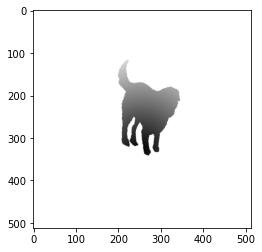

In [221]:
background_grad = cv2.subtract(grad_img,warped)
foreground_grad = cv2.subtract(grad_img,background_grad)
white_bg_grad = np.zeros((512,512,3), dtype='uint8')+255
white_bg_grad = cv2.subtract(white_bg_grad,warped)
shadow_grad = foreground_grad+white_bg_grad
plt.imshow(shadow_grad[...,::-1])

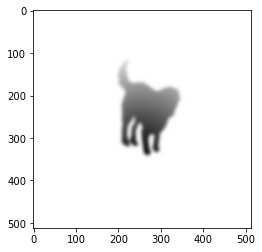

In [222]:
shadow_grad_blur = cv2.GaussianBlur(shadow_grad,(21,21),cv2.BORDER_DEFAULT)
plt.imshow(shadow_grad_blur)

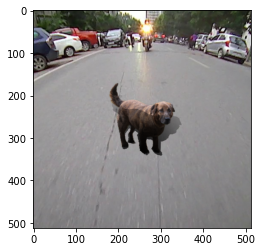

In [12]:
# Convert uint8 to float
# shadow_foreground = shadow_grad_blur.astype(float)
shadow_foreground = shadow_black.astype(float)
img_float = img.astype(float)

# Normalize the alpha mask to keep intensity between 0 and 1
# alpha = warped.astype(float)/255
alpha = grad_img.astype(float)/255
alpha /= 1

# Multiply the foreground with the alpha matte
foreground_shadow = cv2.multiply(alpha, shadow_foreground)

# Multiply the background with ( 1 - alpha )
background_img = cv2.multiply(1.0 - alpha, img_float)

# Add the masked foreground and background.
outImage = cv2.add(foreground_shadow, background_img)
outImage = outImage.astype('uint8')
plt.imshow(outImage[..., ::-1])

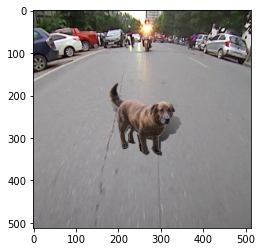

In [27]:
final_background=cv2.subtract(outImage,mask)
final_img = cut_obj+final_background
plt.imshow(final_img[...,::-1])

## Notes:
- Control shadow rotation
- The edges/outlines are too sharp => Tan's post-process pipeline
- Extra pixels of the outline mask => ??? cut shadow mask, not object?

In [39]:
def rotateImage(input, alpha, beta, gamma, dx, dy, dz, f):
    """
    90 degrees being the "normal" position.
    
    alpha: the rotation around the x axis
    beta: the rotation around the y axis
    gamma: the rotation around the z axis (basically a 2D rotation)
    dx: translation along the x axis
    dy: translation along the y axis
    dz: translation along the z axis (distance to the image)
    f: focal distance (distance between camera and image, a smaller number exaggerates the effect)
    """

    alpha = (alpha - 90.)*np.pi/180.
    beta = (beta - 90.)*np.pi/180.
    gamma = (gamma - 90.)*np.pi/180.
    # get width and height for ease of use in matrices
    h, w = input.shape[:2]
    # Projection 2D -> 3D matrix
    A1 = np.array([[1, 0, -w/2],
          [0, 1, -h/2],
          [0, 0,    0],
          [0, 0,    1]])
    # Rotation matrices around the X, Y, and Z axis
    RX = np.array([[1,          0,           0, 0],
          [0, np.cos(alpha), -np.sin(alpha), 0],
          [0, np.sin(alpha),  np.cos(alpha), 0],
          [0,          0,           0, 1]])
    RY = np.array([[np.cos(beta), 0, -np.sin(beta), 0],
          [0, 1,          0, 0],
          [np.sin(beta), 0,  np.cos(beta), 0],
          [0, 0,          0, 1]])
    RZ = np.array([[np.cos(gamma), -np.sin(gamma), 0, 0],
          [np.sin(gamma),  np.cos(gamma), 0, 0],
          [0,          0,           1, 0],
          [0,          0,           0, 1]])
    # Composed rotation matrix with (RX, RY, RZ)
    R = np.matmul(np.matmul(RX, RY), RZ)
    # Translation matrix
    T = np.array([[1, 0, 0, dx],
         [0, 1, 0, dy],
         [0, 0, 1, dz],
         [0, 0, 0, 1]])
    # 3D -> 2D matrix
    A2 = np.array([[f, 0, w/2, 0],
          [0, f, h/2, 0],
          [0, 0,   1, 0]])
    # Final transformation matrix
    trans = np.matmul(A2, np.matmul(T, np.matmul(R, A1)))
    # Apply matrix transformation
    return cv2.warpPerspective(input, trans, (input.shape[0], input.shape[1]), cv2.INTER_LANCZOS4)

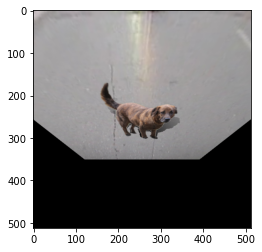

In [43]:
out = rotateImage(final_img, alpha=90+45, beta=90, gamma=90, dx=0, dy=0, dz=200, f=200)
plt.imshow(out[...,::-1])

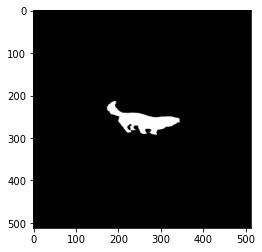

In [50]:
# out = rotateImage(warped, 90+45, 90, 90, 0, 0, 200, 200)
out = rotateImage(warped, alpha=90+55, beta=90, gamma=90, dx=0, dy=0, dz=200, f=200)
plt.imshow(out[...,::-1])

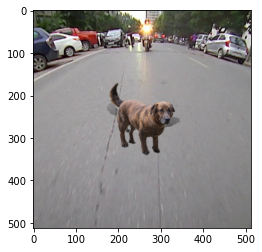

In [51]:
shadow_black = 255-out
shadow_black=cv2.subtract(img,out)
# plt.imshow(shadow_black[...,::-1])
#==========
# Convert uint8 to float
# shadow_foreground = shadow_grad_blur.astype(float)
shadow_foreground = shadow_black.astype(float)
img_float = img.astype(float)

# Normalize the alpha mask to keep intensity between 0 and 1
# alpha = warped.astype(float)/255
alpha = grad_img.astype(float)/255
alpha /= 1

# Multiply the foreground with the alpha matte
foreground_shadow = cv2.multiply(alpha, shadow_foreground)

# Multiply the background with ( 1 - alpha )
background_img = cv2.multiply(1.0 - alpha, img_float)

# Add the masked foreground and background.
outImage = cv2.add(foreground_shadow, background_img)
outImage = outImage.astype('uint8')
# plt.imshow(outImage[..., ::-1])
#==========
final_background=cv2.subtract(outImage,mask)
final_img = cut_obj+final_background
plt.imshow(final_img[...,::-1])

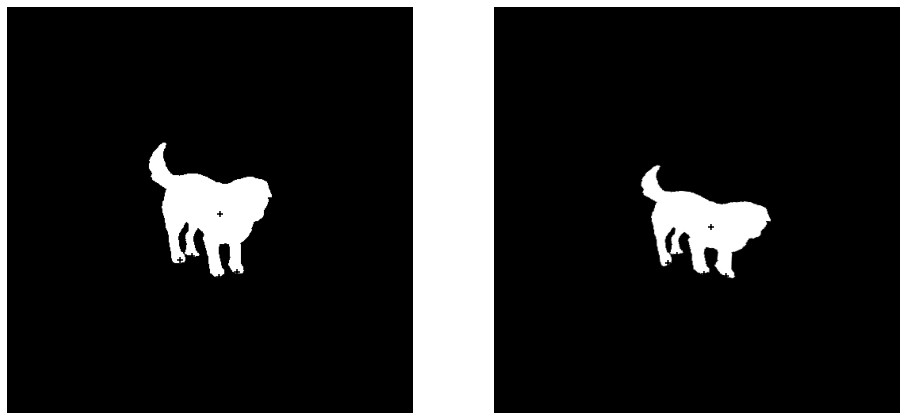

In [24]:
show_warped(mask[...,::-1], warped[...,::-1], c_src, c_dst)